In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CONFIGURATION ---
sf.hbar = 1

# Parameters
eta, delta = 0.9, 0.01
num_steps = 200
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)

learning_rate_mu = 0.0005
learning_rate_epsilon = 0.003


def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu


def classical_fisher(mu, epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Calculate the 2x2 classical Fisher information matrix w.r.t. (eta, delta),
    given the homodyne measurement of quadrature x_mu.
    """
    # Base Wigner
    W_base = prepare_gkp_state(epsilon, eta, delta)
    P_mu = marginal_from_wigner(W_base, quad_axis, mu) + 1e-12

    # dP/d_eta
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta, delta)
    P_eta_plus = marginal_from_wigner(W_eta_plus, quad_axis, mu) + 1e-12
    dP_eta = (P_eta_plus - P_mu) / d_eta

    # dP/d_delta
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta)
    P_delta_plus = marginal_from_wigner(W_delta_plus, quad_axis, mu) + 1e-12
    dP_delta = (P_delta_plus - P_mu) / d_delta

    # Fisher matrix
    F_eta_eta = np.trapz((dP_eta**2) / P_mu, quad_axis)
    F_delta_delta = np.trapz((dP_delta**2) / P_mu, quad_axis)
    F_eta_delta = np.trapz((dP_eta * dP_delta) / P_mu, quad_axis)

    return np.array([[F_eta_eta, F_eta_delta],
                     [F_eta_delta, F_delta_delta]])

def fisher_det_mu(mu, epsilon, eta, delta):
    """To return det(F) for given mu."""
    F = classical_fisher(mu, epsilon, eta, delta)
    return np.linalg.det(F)

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta




# Additional helper function for marginal MSE calculation clearly:
def marginal_mse(epsilon, mu, eta, delta):
    W_ideal = prepare_gkp_state(epsilon, eta=1.0, gamma=0.0)
    W_noisy = prepare_gkp_state(epsilon, eta=eta, gamma=delta)

    P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=mu)
    P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=mu)

    mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
    return mse


def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon



c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:

# --- Initialization ---
epsilon = db_to_epsilon(15)
epsilon_min, epsilon_max = db_to_epsilon(18), db_to_epsilon(10)
mu = 2.3592999716910443  # initial mu

# History recording
epsilon_history, mu_history = [], []
mse_history = []
cfi_history, qfi_history = [], []

velocity_mu, velocity_epsilon = 0, 0
momentum = 0.9

# --- Joint Optimization Loop ---
for step in tqdm(range(num_steps)):
    # --- Compute gradient for mu via CFI ---
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    velocity_mu = momentum * velocity_mu + learning_rate_mu * grad_mu
    mu += velocity_mu
    mu %= (2 * np.pi)

    # --- Compute gradient for epsilon via QFI ---
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)

    velocity_epsilon = momentum * velocity_epsilon + learning_rate_epsilon * grad_epsilon
    epsilon += velocity_epsilon
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)

    # --- Evaluate Fisher information ---
    F_cfi = classical_fisher(mu, epsilon, eta, delta)
    det_F_cfi = np.linalg.det(F_cfi)
    cfi_history.append(det_F_cfi)

    _, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    F_qfi, _, _ = compute_qfi_bound(dW_deta, dW_ddelta)
    qfi_history.append(F_qfi)

    # --- Marginal MSE ---
    mse = marginal_mse(epsilon, mu, eta, delta)
    mse_history.append(mse)

    epsilon_history.append(epsilon)
    mu_history.append(mu)

    if step % 1 == 0 or step == num_steps - 1:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: mu={mu:.4f}, ε={epsilon:.4f} ({db_val:.2f} dB), "
              f"CFI_det={det_F_cfi:.4e}, QFI={F_qfi:.4e}, MSE={mse:.4e}")



  0%|          | 1/200 [12:30<41:30:38, 750.95s/it]

Step 0: mu=2.3593, ε=0.0318 (14.98 dB), CFI_det=3.0470e+03, QFI=1.7105e+02, MSE=1.4633e-01


  1%|          | 2/200 [25:06<41:27:38, 753.83s/it]

Step 1: mu=2.3593, ε=0.0321 (14.94 dB), CFI_det=3.0007e+03, QFI=1.7188e+02, MSE=1.4494e-01


  2%|▏         | 3/200 [37:20<40:45:32, 744.84s/it]

Step 2: mu=2.3593, ε=0.0325 (14.89 dB), CFI_det=2.9342e+03, QFI=1.7303e+02, MSE=1.4310e-01


  2%|▏         | 4/200 [49:26<40:08:31, 737.30s/it]

Step 3: mu=2.3593, ε=0.0330 (14.82 dB), CFI_det=2.8591e+03, QFI=1.7445e+02, MSE=1.4077e-01


  2%|▎         | 5/200 [1:01:22<39:30:29, 729.38s/it]

Step 4: mu=2.3594, ε=0.0336 (14.74 dB), CFI_det=2.7834e+03, QFI=1.7608e+02, MSE=1.3814e-01


  3%|▎         | 6/200 [1:13:08<38:52:40, 721.45s/it]

Step 5: mu=2.3594, ε=0.0343 (14.65 dB), CFI_det=2.6976e+03, QFI=1.7787e+02, MSE=1.3518e-01


  4%|▎         | 7/200 [1:24:43<38:13:00, 712.85s/it]

Step 6: mu=2.3594, ε=0.0351 (14.55 dB), CFI_det=2.5893e+03, QFI=1.7976e+02, MSE=1.3205e-01


  4%|▍         | 8/200 [1:36:06<37:31:08, 703.48s/it]

Step 7: mu=2.3594, ε=0.0359 (14.45 dB), CFI_det=2.4913e+03, QFI=1.8171e+02, MSE=1.2873e-01


  4%|▍         | 9/200 [1:47:06<36:35:52, 689.80s/it]

Step 8: mu=2.3595, ε=0.0369 (14.34 dB), CFI_det=2.3880e+03, QFI=1.8369e+02, MSE=1.2531e-01


  5%|▌         | 10/200 [1:57:53<35:42:44, 676.66s/it]

Step 9: mu=2.3595, ε=0.0378 (14.22 dB), CFI_det=2.3028e+03, QFI=1.8566e+02, MSE=1.2184e-01


  6%|▌         | 11/200 [2:08:29<34:52:08, 664.17s/it]

Step 10: mu=2.3595, ε=0.0389 (14.11 dB), CFI_det=2.1983e+03, QFI=1.8759e+02, MSE=1.1836e-01


  6%|▌         | 12/200 [2:18:50<33:59:29, 650.90s/it]

Step 11: mu=2.3596, ε=0.0399 (13.99 dB), CFI_det=2.1044e+03, QFI=1.8946e+02, MSE=1.1490e-01


  6%|▋         | 13/200 [2:28:57<33:07:40, 637.76s/it]

Step 12: mu=2.3596, ε=0.0411 (13.87 dB), CFI_det=2.0066e+03, QFI=1.9125e+02, MSE=1.1140e-01


  7%|▋         | 14/200 [2:38:53<32:18:16, 625.25s/it]

Step 13: mu=2.3597, ε=0.0422 (13.75 dB), CFI_det=1.9216e+03, QFI=1.9294e+02, MSE=1.0806e-01


  8%|▊         | 15/200 [2:48:37<31:28:58, 612.64s/it]

Step 14: mu=2.3597, ε=0.0434 (13.63 dB), CFI_det=1.8388e+03, QFI=1.9453e+02, MSE=1.0468e-01


  8%|▊         | 16/200 [2:58:09<30:41:12, 600.39s/it]

Step 15: mu=2.3597, ε=0.0446 (13.51 dB), CFI_det=1.7552e+03, QFI=1.9601e+02, MSE=1.0149e-01


  8%|▊         | 17/200 [3:07:26<29:51:40, 587.43s/it]

Step 16: mu=2.3598, ε=0.0459 (13.39 dB), CFI_det=1.6759e+03, QFI=1.9736e+02, MSE=9.8341e-02


  9%|▉         | 18/200 [3:16:33<29:05:17, 575.37s/it]

Step 17: mu=2.3598, ε=0.0472 (13.27 dB), CFI_det=1.6098e+03, QFI=1.9860e+02, MSE=9.5274e-02


 10%|▉         | 19/200 [3:25:29<28:19:56, 563.52s/it]

Step 18: mu=2.3599, ε=0.0485 (13.15 dB), CFI_det=1.5414e+03, QFI=1.9971e+02, MSE=9.2402e-02


 10%|█         | 20/200 [3:34:14<27:36:01, 552.01s/it]

Step 19: mu=2.3599, ε=0.0498 (13.03 dB), CFI_det=1.4750e+03, QFI=2.0070e+02, MSE=8.9590e-02


 10%|█         | 21/200 [3:42:49<26:53:20, 540.78s/it]

Step 20: mu=2.3599, ε=0.0511 (12.92 dB), CFI_det=1.4083e+03, QFI=2.0157e+02, MSE=8.6922e-02


 11%|█         | 22/200 [3:51:16<26:13:51, 530.51s/it]

Step 21: mu=2.3600, ε=0.0525 (12.81 dB), CFI_det=1.3545e+03, QFI=2.0232e+02, MSE=8.4427e-02


 12%|█▏        | 23/200 [3:59:31<25:33:49, 519.94s/it]

Step 22: mu=2.3600, ε=0.0538 (12.69 dB), CFI_det=1.3008e+03, QFI=2.0296e+02, MSE=8.2009e-02


 12%|█▏        | 24/200 [4:07:40<24:58:18, 510.79s/it]

Step 23: mu=2.3601, ε=0.0552 (12.58 dB), CFI_det=1.2442e+03, QFI=2.0348e+02, MSE=7.9610e-02


 12%|█▎        | 25/200 [4:15:43<24:24:53, 502.25s/it]

Step 24: mu=2.3601, ε=0.0566 (12.48 dB), CFI_det=1.1926e+03, QFI=2.0390e+02, MSE=7.7483e-02


 13%|█▎        | 26/200 [4:23:35<23:50:14, 493.19s/it]

Step 25: mu=2.3602, ε=0.0580 (12.37 dB), CFI_det=1.1543e+03, QFI=2.0422e+02, MSE=7.5390e-02


 14%|█▎        | 27/200 [4:31:21<23:18:38, 485.08s/it]

Step 26: mu=2.3602, ε=0.0594 (12.27 dB), CFI_det=1.1027e+03, QFI=2.0443e+02, MSE=7.3318e-02


 14%|█▍        | 28/200 [4:38:58<22:46:53, 476.82s/it]

Step 27: mu=2.3603, ε=0.0608 (12.16 dB), CFI_det=1.0649e+03, QFI=2.0456e+02, MSE=7.1347e-02


 14%|█▍        | 29/200 [4:46:27<22:14:29, 468.24s/it]

Step 28: mu=2.3603, ε=0.0623 (12.06 dB), CFI_det=1.0208e+03, QFI=2.0459e+02, MSE=6.9469e-02


 15%|█▌        | 30/200 [4:53:49<21:44:48, 460.52s/it]

Step 29: mu=2.3604, ε=0.0634 (11.98 dB), CFI_det=9.8632e+02, QFI=2.0456e+02, MSE=6.7988e-02


 16%|█▌        | 31/200 [5:01:10<21:20:15, 454.53s/it]

Step 30: mu=2.3604, ε=0.0643 (11.93 dB), CFI_det=9.7540e+02, QFI=2.0450e+02, MSE=6.6836e-02


 16%|█▌        | 32/200 [5:08:23<20:54:59, 448.21s/it]

Step 31: mu=2.3605, ε=0.0649 (11.88 dB), CFI_det=9.5819e+02, QFI=2.0443e+02, MSE=6.6021e-02


 16%|█▋        | 33/200 [5:15:33<20:32:15, 442.73s/it]

Step 32: mu=2.3605, ε=0.0653 (11.85 dB), CFI_det=9.5323e+02, QFI=2.0438e+02, MSE=6.5442e-02


 17%|█▋        | 34/200 [5:22:41<20:12:13, 438.16s/it]

Step 33: mu=2.3606, ε=0.0656 (11.84 dB), CFI_det=9.4847e+02, QFI=2.0435e+02, MSE=6.5048e-02


 18%|█▊        | 35/200 [5:29:49<19:56:32, 435.11s/it]

Step 34: mu=2.3606, ε=0.0656 (11.84 dB), CFI_det=9.4628e+02, QFI=2.0435e+02, MSE=6.4913e-02


 18%|█▊        | 36/200 [5:36:55<19:42:09, 432.50s/it]

Step 35: mu=2.3607, ε=0.0655 (11.84 dB), CFI_det=9.5896e+02, QFI=2.0436e+02, MSE=6.4897e-02


 18%|█▊        | 37/200 [5:44:02<19:30:31, 430.87s/it]

Step 36: mu=2.3607, ε=0.0653 (11.86 dB), CFI_det=9.6814e+02, QFI=2.0439e+02, MSE=6.5143e-02


 19%|█▉        | 38/200 [5:51:11<19:21:32, 430.20s/it]

Step 37: mu=2.3608, ε=0.0649 (11.88 dB), CFI_det=9.8258e+02, QFI=2.0443e+02, MSE=6.5388e-02


 20%|█▉        | 39/200 [5:58:22<19:15:38, 430.67s/it]

Step 38: mu=2.3608, ε=0.0644 (11.91 dB), CFI_det=1.0006e+03, QFI=2.0448e+02, MSE=6.5967e-02


 20%|██        | 40/200 [6:05:40<19:13:47, 432.67s/it]

Step 39: mu=2.3609, ε=0.0639 (11.95 dB), CFI_det=1.0195e+03, QFI=2.0453e+02, MSE=6.6575e-02


 20%|██        | 41/200 [6:12:59<19:11:52, 434.67s/it]

Step 40: mu=2.3609, ε=0.0632 (12.00 dB), CFI_det=1.0493e+03, QFI=2.0457e+02, MSE=6.7373e-02


 21%|██        | 42/200 [6:20:20<19:09:29, 436.51s/it]

Step 41: mu=2.3610, ε=0.0624 (12.05 dB), CFI_det=1.0752e+03, QFI=2.0459e+02, MSE=6.8283e-02


 22%|██▏       | 43/200 [6:27:43<19:07:36, 438.58s/it]

Step 42: mu=2.3610, ε=0.0616 (12.11 dB), CFI_det=1.0989e+03, QFI=2.0458e+02, MSE=6.9429e-02


 22%|██▏       | 44/200 [6:35:10<19:06:32, 440.98s/it]

Step 43: mu=2.3611, ε=0.0610 (12.15 dB), CFI_det=1.1259e+03, QFI=2.0456e+02, MSE=7.0162e-02


 22%|██▎       | 45/200 [6:42:40<19:06:13, 443.70s/it]

Step 44: mu=2.3611, ε=0.0606 (12.18 dB), CFI_det=1.1392e+03, QFI=2.0454e+02, MSE=7.0825e-02


 23%|██▎       | 46/200 [6:50:12<19:05:22, 446.25s/it]

Step 45: mu=2.3612, ε=0.0604 (12.19 dB), CFI_det=1.1511e+03, QFI=2.0453e+02, MSE=7.1282e-02


 24%|██▎       | 47/200 [6:57:46<19:03:46, 448.54s/it]

Step 46: mu=2.3612, ε=0.0604 (12.20 dB), CFI_det=1.1592e+03, QFI=2.0453e+02, MSE=7.1300e-02


 24%|██▍       | 48/200 [7:05:21<19:01:16, 450.50s/it]

Step 47: mu=2.3613, ε=0.0605 (12.19 dB), CFI_det=1.1557e+03, QFI=2.0454e+02, MSE=7.1309e-02


 24%|██▍       | 49/200 [7:12:51<18:53:38, 450.45s/it]

Step 48: mu=2.3613, ε=0.0608 (12.17 dB), CFI_det=1.1495e+03, QFI=2.0455e+02, MSE=7.1021e-02


 25%|██▌       | 50/200 [7:20:20<18:44:20, 449.74s/it]

Step 49: mu=2.3614, ε=0.0612 (12.14 dB), CFI_det=1.1344e+03, QFI=2.0457e+02, MSE=7.0585e-02


 26%|██▌       | 51/200 [7:27:47<18:35:05, 449.03s/it]

Step 50: mu=2.3614, ε=0.0617 (12.11 dB), CFI_det=1.1161e+03, QFI=2.0459e+02, MSE=6.9943e-02


 26%|██▌       | 52/200 [7:35:11<18:24:07, 447.62s/it]

Step 51: mu=2.3615, ε=0.0623 (12.06 dB), CFI_det=1.1027e+03, QFI=2.0459e+02, MSE=6.9409e-02


 26%|██▋       | 53/200 [7:42:34<18:12:45, 446.02s/it]

Step 52: mu=2.3615, ε=0.0626 (12.04 dB), CFI_det=1.0970e+03, QFI=2.0458e+02, MSE=6.9096e-02


 27%|██▋       | 54/200 [7:49:55<18:02:21, 444.81s/it]

Step 53: mu=2.3616, ε=0.0628 (12.02 dB), CFI_det=1.0989e+03, QFI=2.0458e+02, MSE=6.8859e-02


 28%|██▊       | 55/200 [7:57:18<17:53:18, 444.13s/it]

Step 54: mu=2.3616, ε=0.0629 (12.02 dB), CFI_det=1.1051e+03, QFI=2.0458e+02, MSE=6.8906e-02


 28%|██▊       | 56/200 [8:04:40<17:44:39, 443.61s/it]

Step 55: mu=2.3617, ε=0.0627 (12.03 dB), CFI_det=1.1138e+03, QFI=2.0458e+02, MSE=6.9197e-02


 28%|██▊       | 57/200 [8:12:01<17:35:16, 442.78s/it]

Step 56: mu=2.3617, ε=0.0625 (12.05 dB), CFI_det=1.1368e+03, QFI=2.0459e+02, MSE=6.9653e-02


 29%|██▉       | 58/200 [8:19:23<17:27:22, 442.55s/it]

Step 57: mu=2.3618, ε=0.0621 (12.07 dB), CFI_det=1.1629e+03, QFI=2.0459e+02, MSE=7.0141e-02


 30%|██▉       | 59/200 [8:26:47<17:21:03, 443.00s/it]

Step 58: mu=2.3618, ε=0.0619 (12.09 dB), CFI_det=1.1624e+03, QFI=2.0459e+02, MSE=7.0420e-02


 30%|███       | 60/200 [8:34:13<17:15:22, 443.73s/it]

Step 59: mu=2.3619, ε=0.0619 (12.09 dB), CFI_det=1.1718e+03, QFI=2.0459e+02, MSE=7.0748e-02


 30%|███       | 61/200 [8:41:36<17:07:57, 443.72s/it]

Step 60: mu=2.3619, ε=0.0620 (12.08 dB), CFI_det=1.1781e+03, QFI=2.0459e+02, MSE=7.0573e-02


 31%|███       | 62/200 [8:49:00<17:00:15, 443.59s/it]

Step 61: mu=2.3620, ε=0.0623 (12.06 dB), CFI_det=1.2035e+03, QFI=2.0459e+02, MSE=7.0244e-02


 32%|███▏      | 63/200 [8:56:22<16:52:02, 443.23s/it]

Step 62: mu=2.3620, ε=0.0624 (12.06 dB), CFI_det=1.2017e+03, QFI=2.0459e+02, MSE=7.0107e-02


 32%|███▏      | 64/200 [9:03:46<16:45:04, 443.41s/it]

Step 63: mu=2.3621, ε=0.0623 (12.06 dB), CFI_det=1.2203e+03, QFI=2.0459e+02, MSE=7.0181e-02


 32%|███▎      | 65/200 [9:11:10<16:37:58, 443.54s/it]

Step 64: mu=2.3621, ε=0.0621 (12.08 dB), CFI_det=1.2412e+03, QFI=2.0459e+02, MSE=7.0575e-02


 33%|███▎      | 66/200 [9:18:33<16:30:02, 443.30s/it]

Step 65: mu=2.3622, ε=0.0620 (12.08 dB), CFI_det=1.2619e+03, QFI=2.0459e+02, MSE=7.0645e-02


 34%|███▎      | 67/200 [9:25:56<16:22:51, 443.39s/it]

Step 66: mu=2.3622, ε=0.0621 (12.07 dB), CFI_det=1.2681e+03, QFI=2.0459e+02, MSE=7.0466e-02


 34%|███▍      | 68/200 [9:33:20<16:15:58, 443.62s/it]

Step 67: mu=2.3623, ε=0.0621 (12.08 dB), CFI_det=1.3048e+03, QFI=2.0459e+02, MSE=7.0728e-02


 34%|███▍      | 69/200 [9:40:45<16:09:24, 444.00s/it]

Step 68: mu=2.3623, ε=0.0622 (12.07 dB), CFI_det=1.3233e+03, QFI=2.0459e+02, MSE=7.0507e-02


 35%|███▌      | 70/200 [9:48:08<16:01:26, 443.74s/it]

Step 69: mu=2.3624, ε=0.0621 (12.07 dB), CFI_det=1.3404e+03, QFI=2.0459e+02, MSE=7.0731e-02


 36%|███▌      | 71/200 [9:55:32<15:53:54, 443.67s/it]

Step 70: mu=2.3624, ε=0.0619 (12.09 dB), CFI_det=1.3822e+03, QFI=2.0459e+02, MSE=7.1087e-02


 36%|███▌      | 72/200 [10:02:57<15:47:28, 444.13s/it]

Step 71: mu=2.3625, ε=0.0619 (12.09 dB), CFI_det=1.4025e+03, QFI=2.0459e+02, MSE=7.1234e-02


 36%|███▋      | 73/200 [10:10:22<15:40:28, 444.32s/it]

Step 72: mu=2.3625, ε=0.0620 (12.08 dB), CFI_det=1.4363e+03, QFI=2.0459e+02, MSE=7.1021e-02


 37%|███▋      | 74/200 [10:17:45<15:32:26, 444.02s/it]

Step 73: mu=2.3626, ε=0.0623 (12.06 dB), CFI_det=1.4477e+03, QFI=2.0459e+02, MSE=7.0764e-02


 38%|███▊      | 75/200 [10:25:07<15:23:46, 443.41s/it]

Step 74: mu=2.3626, ε=0.0624 (12.06 dB), CFI_det=1.4547e+03, QFI=2.0459e+02, MSE=7.0731e-02


 38%|███▊      | 76/200 [10:32:30<15:15:56, 443.20s/it]

Step 75: mu=2.3627, ε=0.0623 (12.06 dB), CFI_det=1.5146e+03, QFI=2.0459e+02, MSE=7.1045e-02


 38%|███▊      | 77/200 [10:39:54<15:09:24, 443.61s/it]

Step 76: mu=2.3627, ε=0.0621 (12.08 dB), CFI_det=1.5405e+03, QFI=2.0459e+02, MSE=7.1324e-02


 39%|███▉      | 78/200 [10:47:17<15:01:31, 443.37s/it]

Step 77: mu=2.3628, ε=0.0620 (12.08 dB), CFI_det=1.5666e+03, QFI=2.0459e+02, MSE=7.1620e-02


 40%|███▉      | 79/200 [10:54:40<14:54:03, 443.33s/it]

Step 78: mu=2.3628, ε=0.0621 (12.07 dB), CFI_det=1.5947e+03, QFI=2.0459e+02, MSE=7.1532e-02


 40%|████      | 80/200 [11:02:04<14:46:38, 443.32s/it]

Step 79: mu=2.3629, ε=0.0621 (12.08 dB), CFI_det=1.6456e+03, QFI=2.0459e+02, MSE=7.1786e-02


 40%|████      | 81/200 [11:09:29<14:40:05, 443.74s/it]

Step 80: mu=2.3629, ε=0.0622 (12.07 dB), CFI_det=1.6933e+03, QFI=2.0459e+02, MSE=7.1660e-02


 41%|████      | 82/200 [11:16:55<14:34:15, 444.54s/it]

Step 81: mu=2.3630, ε=0.0621 (12.07 dB), CFI_det=1.6848e+03, QFI=2.0459e+02, MSE=7.1922e-02


 42%|████▏     | 83/200 [11:24:18<14:26:11, 444.20s/it]

Step 82: mu=2.3630, ε=0.0619 (12.09 dB), CFI_det=1.7445e+03, QFI=2.0459e+02, MSE=7.2397e-02


 42%|████▏     | 84/200 [11:31:42<14:18:22, 443.99s/it]

Step 83: mu=2.3631, ε=0.0619 (12.09 dB), CFI_det=1.8325e+03, QFI=2.0459e+02, MSE=7.2571e-02


 42%|████▎     | 85/200 [11:39:06<14:10:54, 443.96s/it]

Step 84: mu=2.3631, ε=0.0620 (12.08 dB), CFI_det=1.8371e+03, QFI=2.0459e+02, MSE=7.2540e-02


 43%|████▎     | 86/200 [11:46:30<14:03:26, 443.92s/it]

Step 85: mu=2.3632, ε=0.0623 (12.06 dB), CFI_det=1.8216e+03, QFI=2.0459e+02, MSE=7.2194e-02


 44%|████▎     | 87/200 [11:53:52<13:54:58, 443.35s/it]

Step 86: mu=2.3632, ε=0.0624 (12.06 dB), CFI_det=1.8257e+03, QFI=2.0459e+02, MSE=7.2083e-02


 44%|████▍     | 88/200 [12:01:14<13:47:07, 443.10s/it]

Step 87: mu=2.3633, ε=0.0623 (12.06 dB), CFI_det=1.8511e+03, QFI=2.0459e+02, MSE=7.2213e-02


 44%|████▍     | 89/200 [12:08:38<13:40:18, 443.41s/it]

Step 88: mu=2.3633, ε=0.0621 (12.08 dB), CFI_det=1.9584e+03, QFI=2.0459e+02, MSE=7.2624e-02


 45%|████▌     | 90/200 [12:16:02<13:33:11, 443.56s/it]

Step 89: mu=2.3634, ε=0.0620 (12.08 dB), CFI_det=1.9892e+03, QFI=2.0459e+02, MSE=7.2830e-02


 46%|████▌     | 91/200 [12:23:25<13:25:29, 443.39s/it]

Step 90: mu=2.3634, ε=0.0621 (12.07 dB), CFI_det=2.0102e+03, QFI=2.0459e+02, MSE=7.2831e-02


 46%|████▌     | 92/200 [12:30:48<13:18:02, 443.36s/it]

Step 91: mu=2.3634, ε=0.0621 (12.07 dB), CFI_det=2.0453e+03, QFI=2.0459e+02, MSE=7.2968e-02


 46%|████▋     | 93/200 [12:38:12<13:10:54, 443.50s/it]

Step 92: mu=2.3635, ε=0.0622 (12.07 dB), CFI_det=2.0554e+03, QFI=2.0459e+02, MSE=7.2925e-02


 47%|████▋     | 94/200 [12:45:36<13:03:54, 443.73s/it]

Step 93: mu=2.3635, ε=0.0621 (12.07 dB), CFI_det=2.1454e+03, QFI=2.0459e+02, MSE=7.3065e-02


 48%|████▊     | 95/200 [12:53:01<12:56:59, 443.99s/it]

Step 94: mu=2.3636, ε=0.0619 (12.09 dB), CFI_det=2.1905e+03, QFI=2.0459e+02, MSE=7.3396e-02


 48%|████▊     | 96/200 [13:00:25<12:49:20, 443.86s/it]

Step 95: mu=2.3636, ε=0.0619 (12.09 dB), CFI_det=2.2155e+03, QFI=2.0459e+02, MSE=7.3601e-02


 48%|████▊     | 97/200 [13:07:49<12:42:23, 444.11s/it]

Step 96: mu=2.3637, ε=0.0620 (12.08 dB), CFI_det=2.1795e+03, QFI=2.0459e+02, MSE=7.3370e-02


 49%|████▉     | 98/200 [13:15:14<12:35:03, 444.15s/it]

Step 97: mu=2.3637, ε=0.0623 (12.06 dB), CFI_det=2.2021e+03, QFI=2.0459e+02, MSE=7.3139e-02


 50%|████▉     | 99/200 [13:22:36<12:26:59, 443.76s/it]

Step 98: mu=2.3638, ε=0.0624 (12.06 dB), CFI_det=2.2722e+03, QFI=2.0459e+02, MSE=7.3122e-02


 50%|█████     | 100/200 [13:29:59<12:19:10, 443.50s/it]

Step 99: mu=2.3638, ε=0.0623 (12.06 dB), CFI_det=2.2918e+03, QFI=2.0459e+02, MSE=7.3411e-02


 50%|█████     | 101/200 [13:37:23<12:11:54, 443.58s/it]

Step 100: mu=2.3639, ε=0.0621 (12.08 dB), CFI_det=2.3213e+03, QFI=2.0459e+02, MSE=7.3725e-02


 51%|█████     | 102/200 [13:44:47<12:04:36, 443.63s/it]

Step 101: mu=2.3639, ε=0.0620 (12.08 dB), CFI_det=2.3740e+03, QFI=2.0459e+02, MSE=7.4135e-02


 52%|█████▏    | 103/200 [13:52:12<11:57:47, 444.00s/it]

Step 102: mu=2.3640, ε=0.0622 (12.07 dB), CFI_det=2.3778e+03, QFI=2.0459e+02, MSE=7.4088e-02


 52%|█████▏    | 104/200 [13:59:35<11:50:11, 443.87s/it]

Step 103: mu=2.3640, ε=0.0621 (12.07 dB), CFI_det=2.4114e+03, QFI=2.0459e+02, MSE=7.3975e-02


 52%|█████▎    | 105/200 [14:06:59<11:42:30, 443.69s/it]

Step 104: mu=2.3641, ε=0.0622 (12.07 dB), CFI_det=2.4603e+03, QFI=2.0459e+02, MSE=7.4069e-02


 53%|█████▎    | 106/200 [14:14:22<11:34:54, 443.56s/it]

Step 105: mu=2.3641, ε=0.0621 (12.07 dB), CFI_det=2.4941e+03, QFI=2.0459e+02, MSE=7.4378e-02


 54%|█████▎    | 107/200 [14:21:46<11:27:43, 443.69s/it]

Step 106: mu=2.3642, ε=0.0619 (12.09 dB), CFI_det=2.5891e+03, QFI=2.0459e+02, MSE=7.4675e-02


 54%|█████▍    | 108/200 [14:29:09<11:20:10, 443.60s/it]

Step 107: mu=2.3642, ε=0.0619 (12.09 dB), CFI_det=2.6216e+03, QFI=2.0459e+02, MSE=7.4721e-02


 55%|█████▍    | 109/200 [14:36:34<11:13:10, 443.85s/it]

Step 108: mu=2.3643, ε=0.0620 (12.08 dB), CFI_det=2.6442e+03, QFI=2.0459e+02, MSE=7.4646e-02


 55%|█████▌    | 110/200 [14:43:57<11:05:42, 443.80s/it]

Step 109: mu=2.3643, ε=0.0623 (12.06 dB), CFI_det=2.6334e+03, QFI=2.0459e+02, MSE=7.4410e-02


 56%|█████▌    | 111/200 [14:51:21<10:58:08, 443.69s/it]

Step 110: mu=2.3644, ε=0.0624 (12.06 dB), CFI_det=2.6936e+03, QFI=2.0459e+02, MSE=7.4401e-02


 56%|█████▌    | 112/200 [14:58:44<10:50:27, 443.49s/it]

Step 111: mu=2.3644, ε=0.0623 (12.06 dB), CFI_det=2.7265e+03, QFI=2.0459e+02, MSE=7.4647e-02


 56%|█████▋    | 113/200 [15:06:07<10:42:58, 443.43s/it]

Step 112: mu=2.3645, ε=0.0621 (12.08 dB), CFI_det=2.7812e+03, QFI=2.0459e+02, MSE=7.4876e-02


 57%|█████▋    | 114/200 [15:13:30<10:35:24, 443.30s/it]

Step 113: mu=2.3645, ε=0.0620 (12.08 dB), CFI_det=2.7753e+03, QFI=2.0459e+02, MSE=7.4826e-02


 57%|█████▊    | 115/200 [15:20:55<10:28:38, 443.74s/it]

Step 114: mu=2.3646, ε=0.0622 (12.07 dB), CFI_det=2.7610e+03, QFI=2.0459e+02, MSE=7.4405e-02


 58%|█████▊    | 116/200 [15:28:19<10:21:26, 443.89s/it]

Step 115: mu=2.3646, ε=0.0621 (12.07 dB), CFI_det=2.8177e+03, QFI=2.0459e+02, MSE=7.4626e-02


 58%|█████▊    | 117/200 [15:35:42<10:13:49, 443.72s/it]

Step 116: mu=2.3647, ε=0.0622 (12.07 dB), CFI_det=2.8526e+03, QFI=2.0459e+02, MSE=7.4399e-02


 59%|█████▉    | 118/200 [15:43:05<10:06:04, 443.47s/it]

Step 117: mu=2.3647, ε=0.0621 (12.07 dB), CFI_det=2.8751e+03, QFI=2.0459e+02, MSE=7.4477e-02


 60%|█████▉    | 119/200 [15:50:28<9:58:35, 443.40s/it] 

Step 118: mu=2.3648, ε=0.0619 (12.09 dB), CFI_det=2.9280e+03, QFI=2.0459e+02, MSE=7.4689e-02


 60%|██████    | 120/200 [15:57:52<9:51:20, 443.51s/it]

Step 119: mu=2.3648, ε=0.0619 (12.09 dB), CFI_det=2.9332e+03, QFI=2.0459e+02, MSE=7.4461e-02


 60%|██████    | 121/200 [16:05:17<9:44:31, 443.94s/it]

Step 120: mu=2.3649, ε=0.0620 (12.08 dB), CFI_det=2.9376e+03, QFI=2.0459e+02, MSE=7.4284e-02


 61%|██████    | 122/200 [16:12:40<9:36:48, 443.70s/it]

Step 121: mu=2.3649, ε=0.0623 (12.06 dB), CFI_det=2.8801e+03, QFI=2.0459e+02, MSE=7.3720e-02


 62%|██████▏   | 123/200 [16:20:03<9:29:03, 443.42s/it]

Step 122: mu=2.3650, ε=0.0624 (12.06 dB), CFI_det=2.8745e+03, QFI=2.0459e+02, MSE=7.3488e-02


 62%|██████▏   | 124/200 [16:27:26<9:21:39, 443.42s/it]

Step 123: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8428e+03, QFI=2.0459e+02, MSE=7.3574e-02


 62%|██████▎   | 125/200 [16:34:51<9:14:37, 443.70s/it]

Step 124: mu=2.3651, ε=0.0621 (12.08 dB), CFI_det=2.9229e+03, QFI=2.0459e+02, MSE=7.3743e-02


 63%|██████▎   | 126/200 [16:42:14<9:06:58, 443.49s/it]

Step 125: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.9603e+03, QFI=2.0459e+02, MSE=7.3452e-02


 64%|██████▎   | 127/200 [16:49:38<8:59:40, 443.57s/it]

Step 126: mu=2.3652, ε=0.0622 (12.07 dB), CFI_det=2.9546e+03, QFI=2.0459e+02, MSE=7.3225e-02


 64%|██████▍   | 128/200 [16:57:02<8:52:36, 443.84s/it]

Step 127: mu=2.3652, ε=0.0621 (12.07 dB), CFI_det=2.9733e+03, QFI=2.0459e+02, MSE=7.3335e-02


 64%|██████▍   | 129/200 [17:04:26<8:45:22, 443.98s/it]

Step 128: mu=2.3652, ε=0.0622 (12.07 dB), CFI_det=2.9344e+03, QFI=2.0459e+02, MSE=7.3058e-02


 65%|██████▌   | 130/200 [17:11:49<8:37:19, 443.43s/it]

Step 129: mu=2.3652, ε=0.0621 (12.07 dB), CFI_det=2.9445e+03, QFI=2.0459e+02, MSE=7.3129e-02


 66%|██████▌   | 131/200 [17:19:12<8:29:58, 443.46s/it]

Step 130: mu=2.3652, ε=0.0619 (12.09 dB), CFI_det=2.9799e+03, QFI=2.0459e+02, MSE=7.3415e-02


 66%|██████▌   | 132/200 [17:26:35<8:22:31, 443.40s/it]

Step 131: mu=2.3652, ε=0.0619 (12.09 dB), CFI_det=2.9855e+03, QFI=2.0459e+02, MSE=7.3459e-02


 66%|██████▋   | 133/200 [17:34:00<8:15:34, 443.80s/it]

Step 132: mu=2.3652, ε=0.0620 (12.08 dB), CFI_det=2.9638e+03, QFI=2.0459e+02, MSE=7.3286e-02


 67%|██████▋   | 134/200 [17:41:24<8:08:11, 443.81s/it]

Step 133: mu=2.3652, ε=0.0623 (12.06 dB), CFI_det=2.9409e+03, QFI=2.0459e+02, MSE=7.3016e-02


 68%|██████▊   | 135/200 [17:48:47<8:00:33, 443.59s/it]

Step 134: mu=2.3652, ε=0.0624 (12.06 dB), CFI_det=2.9294e+03, QFI=2.0459e+02, MSE=7.2911e-02


 68%|██████▊   | 136/200 [17:56:09<7:52:38, 443.10s/it]

Step 135: mu=2.3652, ε=0.0623 (12.06 dB), CFI_det=2.9238e+03, QFI=2.0459e+02, MSE=7.3049e-02


 68%|██████▊   | 137/200 [18:03:34<7:45:50, 443.66s/it]

Step 136: mu=2.3651, ε=0.0621 (12.08 dB), CFI_det=2.9476e+03, QFI=2.0459e+02, MSE=7.3380e-02


 69%|██████▉   | 138/200 [18:10:57<7:38:21, 443.58s/it]

Step 137: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.9594e+03, QFI=2.0459e+02, MSE=7.3708e-02


 70%|██████▉   | 139/200 [18:18:22<7:31:17, 443.89s/it]

Step 138: mu=2.3651, ε=0.0622 (12.07 dB), CFI_det=2.9115e+03, QFI=2.0459e+02, MSE=7.3656e-02


 70%|███████   | 140/200 [18:25:45<7:23:39, 443.66s/it]

Step 139: mu=2.3651, ε=0.0621 (12.07 dB), CFI_det=2.9473e+03, QFI=2.0459e+02, MSE=7.3858e-02


 70%|███████   | 141/200 [18:33:09<7:16:27, 443.86s/it]

Step 140: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8567e+03, QFI=2.0459e+02, MSE=7.3710e-02


 71%|███████   | 142/200 [18:40:33<7:08:58, 443.76s/it]

Step 141: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8766e+03, QFI=2.0459e+02, MSE=7.3787e-02


 72%|███████▏  | 143/200 [18:47:57<7:01:33, 443.74s/it]

Step 142: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.9526e+03, QFI=2.0459e+02, MSE=7.4093e-02


 72%|███████▏  | 144/200 [18:55:20<6:54:00, 443.58s/it]

Step 143: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.9662e+03, QFI=2.0459e+02, MSE=7.4139e-02


 72%|███████▎  | 145/200 [19:02:45<6:47:11, 444.21s/it]

Step 144: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.9414e+03, QFI=2.0459e+02, MSE=7.3918e-02


 73%|███████▎  | 146/200 [19:10:10<6:40:00, 444.45s/it]

Step 145: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8952e+03, QFI=2.0459e+02, MSE=7.3552e-02


 74%|███████▎  | 147/200 [19:17:34<6:32:22, 444.19s/it]

Step 146: mu=2.3650, ε=0.0624 (12.06 dB), CFI_det=2.8720e+03, QFI=2.0459e+02, MSE=7.3478e-02


 74%|███████▍  | 148/200 [19:24:57<6:24:35, 443.75s/it]

Step 147: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8876e+03, QFI=2.0459e+02, MSE=7.3593e-02


 74%|███████▍  | 149/200 [19:32:22<6:17:28, 444.09s/it]

Step 148: mu=2.3650, ε=0.0621 (12.08 dB), CFI_det=2.8847e+03, QFI=2.0459e+02, MSE=7.3867e-02


 75%|███████▌  | 150/200 [19:39:55<6:12:30, 447.01s/it]

Step 149: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.8840e+03, QFI=2.0459e+02, MSE=7.3940e-02


 76%|███████▌  | 151/200 [19:47:35<6:08:12, 450.86s/it]

Step 150: mu=2.3651, ε=0.0622 (12.07 dB), CFI_det=2.8690e+03, QFI=2.0459e+02, MSE=7.3792e-02


 76%|███████▌  | 152/200 [19:55:21<6:04:09, 455.20s/it]

Step 151: mu=2.3651, ε=0.0621 (12.07 dB), CFI_det=2.9260e+03, QFI=2.0459e+02, MSE=7.3851e-02


 76%|███████▋  | 153/200 [20:03:04<5:58:34, 457.76s/it]

Step 152: mu=2.3651, ε=0.0622 (12.07 dB), CFI_det=2.8999e+03, QFI=2.0459e+02, MSE=7.3634e-02


 77%|███████▋  | 154/200 [20:10:34<5:49:05, 455.34s/it]

Step 153: mu=2.3651, ε=0.0621 (12.07 dB), CFI_det=2.9096e+03, QFI=2.0459e+02, MSE=7.3707e-02


 78%|███████▊  | 155/200 [20:18:03<5:40:08, 453.53s/it]

Step 154: mu=2.3651, ε=0.0619 (12.09 dB), CFI_det=2.9443e+03, QFI=2.0459e+02, MSE=7.4019e-02


 78%|███████▊  | 156/200 [20:25:32<5:31:32, 452.11s/it]

Step 155: mu=2.3651, ε=0.0619 (12.09 dB), CFI_det=2.9589e+03, QFI=2.0459e+02, MSE=7.4118e-02


 78%|███████▊  | 157/200 [20:33:02<5:23:33, 451.47s/it]

Step 156: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.8890e+03, QFI=2.0459e+02, MSE=7.3958e-02


 79%|███████▉  | 158/200 [20:40:32<5:15:45, 451.08s/it]

Step 157: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8401e+03, QFI=2.0459e+02, MSE=7.3579e-02


 80%|███████▉  | 159/200 [20:53:14<6:11:59, 544.37s/it]

Step 158: mu=2.3650, ε=0.0624 (12.06 dB), CFI_det=2.8306e+03, QFI=2.0459e+02, MSE=7.3459e-02


 80%|████████  | 160/200 [21:08:29<7:16:54, 655.36s/it]

Step 159: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8547e+03, QFI=2.0459e+02, MSE=7.3566e-02


 80%|████████  | 161/200 [21:23:46<7:57:07, 734.03s/it]

Step 160: mu=2.3650, ε=0.0621 (12.08 dB), CFI_det=2.8793e+03, QFI=2.0459e+02, MSE=7.3876e-02


 81%|████████  | 162/200 [21:38:54<8:17:48, 786.02s/it]

Step 161: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.8831e+03, QFI=2.0459e+02, MSE=7.3934e-02


 82%|████████▏ | 163/200 [21:54:16<8:29:53, 826.85s/it]

Step 162: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8685e+03, QFI=2.0459e+02, MSE=7.3792e-02


 82%|████████▏ | 164/200 [22:09:13<8:28:52, 848.13s/it]

Step 163: mu=2.3651, ε=0.0621 (12.07 dB), CFI_det=2.8773e+03, QFI=2.0459e+02, MSE=7.3878e-02


 82%|████████▎ | 165/200 [22:24:08<8:22:55, 862.17s/it]

Step 164: mu=2.3651, ε=0.0622 (12.07 dB), CFI_det=2.8597e+03, QFI=2.0459e+02, MSE=7.3730e-02


 83%|████████▎ | 166/200 [22:39:13<8:15:42, 874.78s/it]

Step 165: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8693e+03, QFI=2.0459e+02, MSE=7.3800e-02


 84%|████████▎ | 167/200 [22:54:42<8:10:04, 891.05s/it]

Step 166: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.9039e+03, QFI=2.0459e+02, MSE=7.4088e-02


 84%|████████▍ | 168/200 [23:10:01<7:59:47, 899.61s/it]

Step 167: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.9051e+03, QFI=2.0459e+02, MSE=7.4125e-02


 84%|████████▍ | 169/200 [23:24:56<7:44:03, 898.19s/it]

Step 168: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.8839e+03, QFI=2.0459e+02, MSE=7.3950e-02


 85%|████████▌ | 170/200 [23:40:01<7:30:06, 900.21s/it]

Step 169: mu=2.3651, ε=0.0623 (12.06 dB), CFI_det=2.8443e+03, QFI=2.0459e+02, MSE=7.3587e-02


 86%|████████▌ | 171/200 [23:48:19<6:16:49, 779.63s/it]

Step 170: mu=2.3651, ε=0.0624 (12.06 dB), CFI_det=2.8322e+03, QFI=2.0459e+02, MSE=7.3465e-02


 86%|████████▌ | 172/200 [23:55:55<5:18:30, 682.52s/it]

Step 171: mu=2.3651, ε=0.0623 (12.06 dB), CFI_det=2.9115e+03, QFI=2.0459e+02, MSE=7.3565e-02


 86%|████████▋ | 173/200 [24:03:34<4:36:56, 615.42s/it]

Step 172: mu=2.3651, ε=0.0621 (12.08 dB), CFI_det=2.8810e+03, QFI=2.0459e+02, MSE=7.3879e-02


 87%|████████▋ | 174/200 [24:11:05<4:05:19, 566.15s/it]

Step 173: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.8876e+03, QFI=2.0459e+02, MSE=7.3948e-02


 88%|████████▊ | 175/200 [24:18:41<3:42:08, 533.12s/it]

Step 174: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8642e+03, QFI=2.0459e+02, MSE=7.3784e-02


 88%|████████▊ | 176/200 [24:31:36<4:02:15, 605.63s/it]

Step 175: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8730e+03, QFI=2.0459e+02, MSE=7.3858e-02


 88%|████████▊ | 177/200 [24:46:27<4:24:56, 691.14s/it]

Step 176: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8555e+03, QFI=2.0459e+02, MSE=7.3711e-02


 89%|████████▉ | 178/200 [25:01:05<4:34:01, 747.33s/it]

Step 177: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8653e+03, QFI=2.0459e+02, MSE=7.3798e-02


 90%|████████▉ | 179/200 [25:15:47<4:35:37, 787.52s/it]

Step 178: mu=2.3651, ε=0.0619 (12.09 dB), CFI_det=2.9048e+03, QFI=2.0459e+02, MSE=7.4088e-02


 90%|█████████ | 180/200 [25:30:23<4:31:24, 814.21s/it]

Step 179: mu=2.3651, ε=0.0619 (12.09 dB), CFI_det=2.9111e+03, QFI=2.0459e+02, MSE=7.4129e-02


 90%|█████████ | 181/200 [25:45:02<4:23:57, 833.54s/it]

Step 180: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.8900e+03, QFI=2.0459e+02, MSE=7.3955e-02


 91%|█████████ | 182/200 [25:59:42<4:14:13, 847.44s/it]

Step 181: mu=2.3651, ε=0.0623 (12.06 dB), CFI_det=2.8443e+03, QFI=2.0459e+02, MSE=7.3599e-02


 92%|█████████▏| 183/200 [26:14:21<4:02:47, 856.93s/it]

Step 182: mu=2.3650, ε=0.0624 (12.06 dB), CFI_det=2.8263e+03, QFI=2.0459e+02, MSE=7.3460e-02


 92%|█████████▏| 184/200 [26:28:56<3:50:00, 862.52s/it]

Step 183: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8386e+03, QFI=2.0459e+02, MSE=7.3553e-02


 92%|█████████▎| 185/200 [26:43:36<3:36:56, 867.76s/it]

Step 184: mu=2.3650, ε=0.0621 (12.08 dB), CFI_det=2.8752e+03, QFI=2.0459e+02, MSE=7.3872e-02


 93%|█████████▎| 186/200 [26:58:21<3:23:41, 872.98s/it]

Step 185: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.8830e+03, QFI=2.0459e+02, MSE=7.3947e-02


 94%|█████████▎| 187/200 [27:13:22<3:10:58, 881.42s/it]

Step 186: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8644e+03, QFI=2.0459e+02, MSE=7.3790e-02


 94%|█████████▍| 188/200 [27:28:15<2:56:56, 884.71s/it]

Step 187: mu=2.3651, ε=0.0621 (12.07 dB), CFI_det=2.8773e+03, QFI=2.0459e+02, MSE=7.3879e-02


 94%|█████████▍| 189/200 [27:43:02<2:42:19, 885.37s/it]

Step 188: mu=2.3651, ε=0.0622 (12.07 dB), CFI_det=2.8597e+03, QFI=2.0459e+02, MSE=7.3731e-02


 95%|█████████▌| 190/200 [27:57:39<2:27:10, 883.06s/it]

Step 189: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8653e+03, QFI=2.0459e+02, MSE=7.3798e-02


 96%|█████████▌| 191/200 [28:12:18<2:12:14, 881.63s/it]

Step 190: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.8998e+03, QFI=2.0459e+02, MSE=7.4086e-02


 96%|█████████▌| 192/200 [28:26:54<1:57:20, 880.06s/it]

Step 191: mu=2.3650, ε=0.0619 (12.09 dB), CFI_det=2.9051e+03, QFI=2.0459e+02, MSE=7.4125e-02


 96%|█████████▋| 193/200 [28:41:35<1:42:42, 880.34s/it]

Step 192: mu=2.3650, ε=0.0620 (12.08 dB), CFI_det=2.8839e+03, QFI=2.0459e+02, MSE=7.3950e-02


 97%|█████████▋| 194/200 [28:56:23<1:28:14, 882.46s/it]

Step 193: mu=2.3650, ε=0.0623 (12.06 dB), CFI_det=2.8443e+03, QFI=2.0459e+02, MSE=7.3587e-02


 98%|█████████▊| 195/200 [29:11:12<1:13:42, 884.51s/it]

Step 194: mu=2.3651, ε=0.0624 (12.06 dB), CFI_det=2.8313e+03, QFI=2.0459e+02, MSE=7.3467e-02


 98%|█████████▊| 196/200 [29:25:55<58:56, 884.24s/it]  

Step 195: mu=2.3651, ε=0.0623 (12.06 dB), CFI_det=2.9099e+03, QFI=2.0459e+02, MSE=7.3568e-02


 98%|█████████▊| 197/200 [29:40:35<44:08, 882.88s/it]

Step 196: mu=2.3651, ε=0.0621 (12.08 dB), CFI_det=2.8810e+03, QFI=2.0459e+02, MSE=7.3879e-02


 99%|█████████▉| 198/200 [29:55:19<29:26, 883.03s/it]

Step 197: mu=2.3651, ε=0.0620 (12.08 dB), CFI_det=2.8876e+03, QFI=2.0459e+02, MSE=7.3948e-02


100%|█████████▉| 199/200 [30:09:57<14:41, 881.74s/it]

Step 198: mu=2.3650, ε=0.0622 (12.07 dB), CFI_det=2.8642e+03, QFI=2.0459e+02, MSE=7.3784e-02


100%|██████████| 200/200 [30:24:31<00:00, 547.36s/it]

Step 199: mu=2.3650, ε=0.0621 (12.07 dB), CFI_det=2.8730e+03, QFI=2.0459e+02, MSE=7.3845e-02


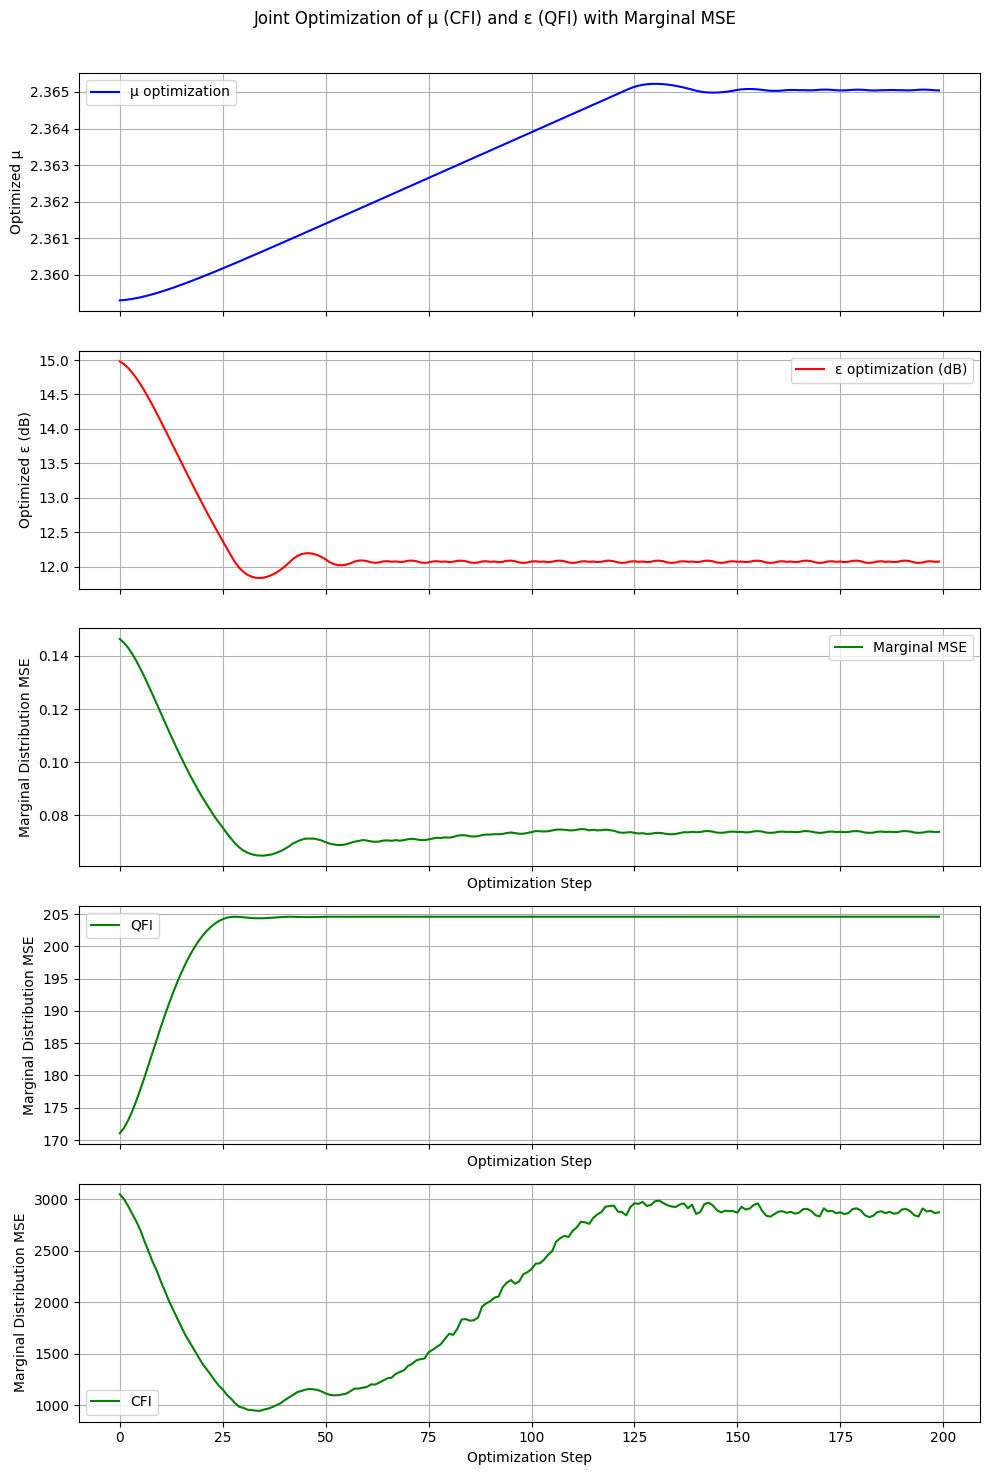

In [3]:
# --- Plot Results ---
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
# Plot μ history
axes[0].plot(mu_history, 'b-', markersize=3, label='μ optimization')
axes[0].set_ylabel('Optimized μ')
axes[0].legend()
axes[0].grid(True)

# Plot ε history
epsilon_db_history = [epsilon_to_db(ep) for ep in epsilon_history]
axes[1].plot(epsilon_db_history, 'r-', markersize=3, label='ε optimization (dB)')
axes[1].set_ylabel('Optimized ε (dB)')
axes[1].legend()
axes[1].grid(True)

# Plot marginal MSE
axes[2].plot(mse_history, 'g-', markersize=3, label='Marginal MSE')
axes[2].set_ylabel('Marginal Distribution MSE')
axes[2].set_xlabel('Optimization Step')
axes[2].legend()
axes[2].grid(True)

# Plot marginal MSE
axes[3].plot(qfi_history, 'g-', markersize=3, label='QFI')
axes[3].set_ylabel('Marginal Distribution MSE')
axes[3].set_xlabel('Optimization Step')
axes[3].legend()
axes[3].grid(True)

# Plot marginal MSE
axes[4].plot(cfi_history, 'g-', markersize=3, label='CFI')
axes[4].set_ylabel('Marginal Distribution MSE')
axes[4].set_xlabel('Optimization Step')
axes[4].legend()
axes[4].grid(True)

plt.suptitle('Joint Optimization of μ (CFI) and ε (QFI) with Marginal MSE')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [4]:
# --- File Paths ---
filename_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15.txt"
data_to_save = np.column_stack((mu_history, epsilon_history, mse_history, qfi_history, cfi_history))

# Define header
header = "mu\t epsilon\t mse\t qfi\t cfi_det"

# Save to file
np.savetxt(filename_path, data_to_save, header=header, delimiter="\t", fmt='%.8e')

print("Optimization data saved")


Optimization data saved


In [7]:
import numpy as np

filename_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15.txt"

# Load the data; 'skiprows=1' to ignore the header line
loaded_data = np.loadtxt(filename_path, delimiter="\t", skiprows=1)

# Each column in 'loaded_data' corresponds to what you saved:
# mu_history, epsilon_history, mse_history, qfi_history, cfi_history
mu_loaded = loaded_data[:, 0]
epsilon_loaded = loaded_data[:, 1]
mse_loaded = loaded_data[:, 2]
qfi_loaded = loaded_data[:, 3]
cfi_loaded = loaded_data[:, 4]


# Plot CFI and QFI

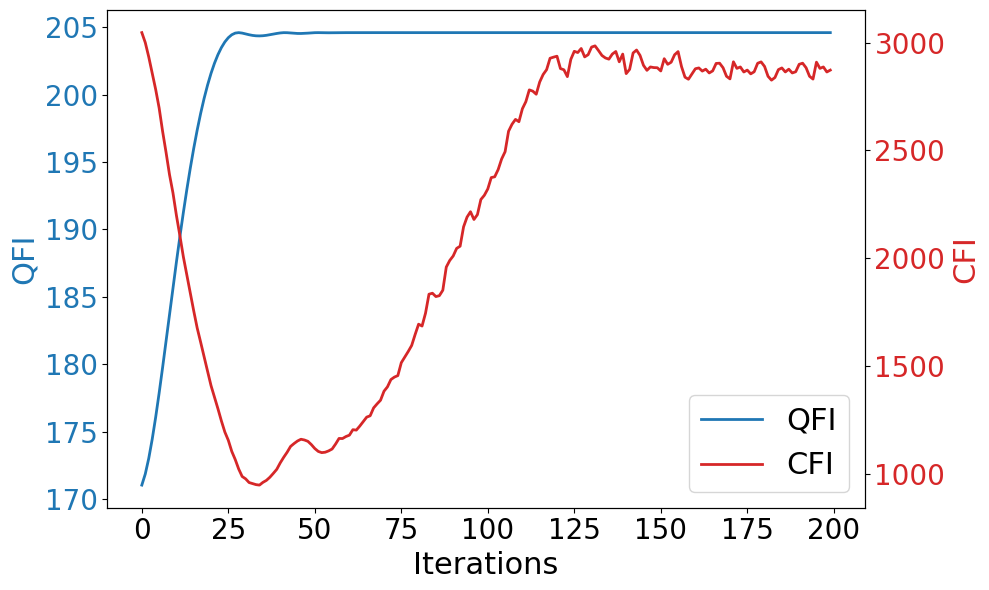

In [12]:
import matplotlib.pyplot as plt

steps_to_plot = 200  

fig, ax1 = plt.subplots(figsize=(10, 6))

color_qfi = 'tab:blue'
color_cfi = 'tab:red'

# Slice data to the first 70 steps
qfi_to_plot = qfi_history[:steps_to_plot]
cfi_to_plot = cfi_history[:steps_to_plot]

# Plot QFI on primary y-axis
ax1.set_xlabel('Iterations', fontsize=22)
ax1.set_ylabel('QFI', fontsize=22, color=color_qfi)
ax1.plot(range(steps_to_plot), qfi_to_plot, color=color_qfi, linewidth=2, label='QFI')
ax1.tick_params(axis='y', labelcolor=color_qfi, labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Create secondary y-axis for squeezing
ax2 = ax1.twinx()
ax2.set_ylabel('CFI', fontsize=22, color=color_cfi)
ax2.plot(range(steps_to_plot), cfi_to_plot, 
         color=color_cfi, linewidth=2, label='CFI')
ax2.tick_params(axis='y', labelcolor=color_cfi, labelsize=20)

# ax1.grid(True)

# Legends (optional, recommended)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lines_qfi, labels_qfi = ax1.get_legend_handles_labels()
lines_squeeze, labels_squeeze = ax2.get_legend_handles_labels()
ax1.legend(lines_qfi + lines_squeeze, labels_qfi + labels_squeeze, fontsize=22, loc='best')

plt.tight_layout()
plt.savefig('simul_QFI_CFI.png', dpi=1000)
plt.show()


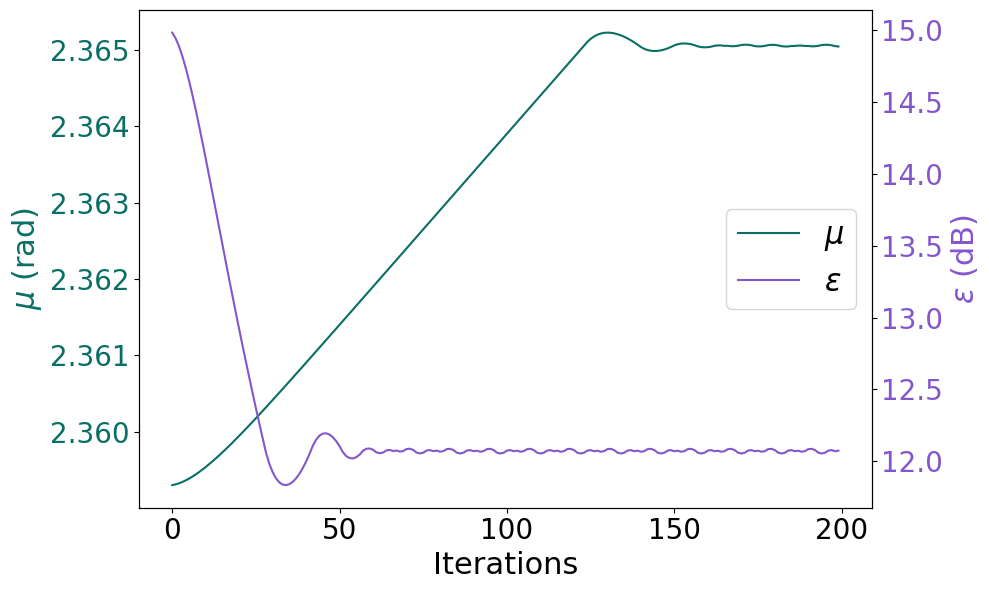

In [58]:
import matplotlib.pyplot as plt

to_plot = 200
# Convert epsilon to dB
epsilon_db_history = [epsilon_to_db(eps) for eps in epsilon_history[:to_plot]]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis (left) for Mu
color = '#096f64'
ax1.set_xlabel('Iterations', fontsize=22)
ax1.set_ylabel(f'$\mu$ (rad)', color=color, fontsize=22)
line1, = ax1.plot(mu_history[:to_plot], color=color, label=f'$\mu$')
ax1.tick_params(axis='y', labelcolor=color,  labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Second axis (right) for Epsilon in dB
ax2 = ax1.twinx()
color = '#8456ce'
ax2.set_ylabel(f'$\epsilon$ (dB)', color=color, fontsize=22)
line2, = ax2.plot(epsilon_db_history, color=color, label=f'$\epsilon$')
ax2.tick_params(axis='y', labelcolor=color,  labelsize=20)


# Add legends clearly
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=22, loc='center right')

fig.tight_layout()

plt.savefig('simul_ep_mu.png', dpi=1000)
plt.show()


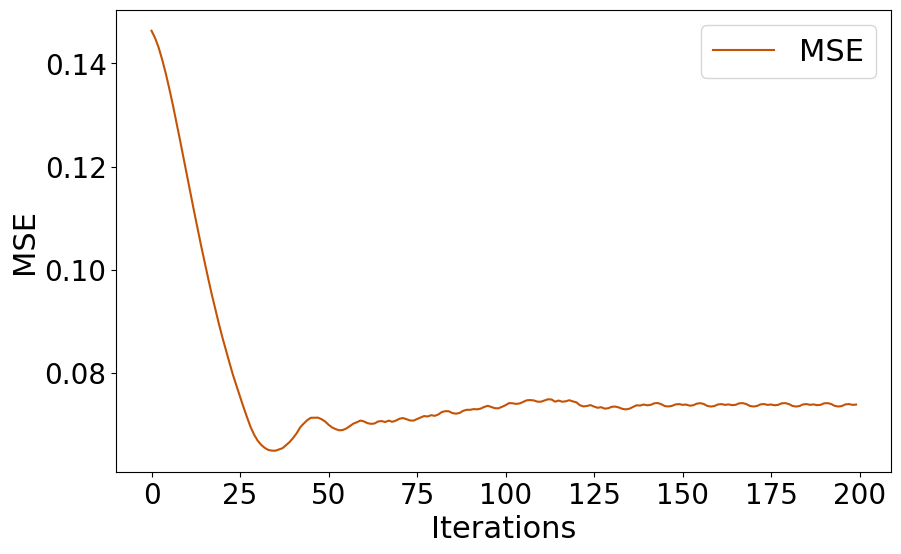

In [59]:
# --- Plot MSE vs. Iterations ---
to_plot = 200
fig2, ax2 = plt.subplots(figsize=(10, 6))

ax2.set_xlabel('Iterations', fontsize=22)
ax2.set_ylabel('MSE', fontsize=22)

# Plot MSE in a custom color (e.g., red)
line2, = ax2.plot(mse_loaded[:to_plot], color='#c55305', label='MSE')

ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

# Pass the list of handles and labels to legend
ax2.legend([line2], ['MSE'], fontsize=22, loc='best')

plt.savefig('simul_MSE.png', dpi=1000)
plt.show()
